# Predict of Reaction Density and Evolution of Reaction Density

In [1]:
import re

import matplotlib.pyplot as plt
import pandas as pd

## Load dataset

In [2]:
dataset = pd.read_csv('C:/MyData/Versetzungsdaten/delta_sampled_merged_last_voxel_data_size2400_order2_speedUp2.csv')
dataset.drop(columns=list(dataset)[0], inplace=True) # drop 1st column (unnamed id column)
print(dataset.shape)

(2750, 6737)


This is the same dataset as used in the paper "Data-driven exploration and continuum modeling of dislocation networks" by Sudmanns et al.

## Define features and target

We consider to prediction scenarios:
- absolute reaction density (which is not really interesting according to a domain expert)
- evolution of reaction density, i.e., difference from some point in time to another point in time (which probably is more difficult to predict)

In [3]:
prediction_problems = []

Just to demonstrate how absolute value and evolution of a quantity (like reaction density) are related in the dataset:
The dataset contains

- the absolute value of the quantity at the current macro-time step (e.g., `rho_glissile_x`)
- the absolute value of the quantity at the previous macro-time step (e.g., `0_rho_glissile_x`); attention: usually this is 50 micro-time steps ago, but not always, as there are some larger gaps
- the delta between current and previous value of the quantity in a normalized form, i.e., per micro-time-step (e.g., `delta_rho_glissile_1`)

Below, we demonstrate for one quantity that the expected relationship between these columns in the dataset holds for all voxels:

In [4]:
numerical_diffs = []
for name, group in dataset.sort_values(by='time').groupby(by=['pos_x', 'pos_y', 'pos_z']):
    group = group.copy()
    group['time_diff'] = group['time'] - group['time'].shift()
    group = group[1:] # remove first data object, which has no predecessor
    numerical_diffs.append((group['rho_glissile_1'] - group['0_rho_glissile_1'] -
                            group['delta_rho_glissile_1'] * group['time_diff']).abs().sum())
pd.Series(numerical_diffs).describe()

count    1.250000e+02
mean     1.695382e-13
std      2.804409e-13
min      0.000000e+00
25%      8.881784e-15
50%      5.329071e-14
75%      2.142730e-13
max      2.290612e-12
dtype: float64

We can see that the columns add up as expected, apart from a small numerical error close to 0.

### Subset dataset

To have a more homogenous dataset (in particular, for the evolution scenario), we select a subset of macro-time steps without gaps between them.
This was also proposed by a domain expert.
We select the largest of the time-step subsets.

In [5]:
times = pd.DataFrame({'time': dataset['time'].sort_values().unique()})
times['time_diff'] = times - times.shift()
times['group'] = (times['time_diff'] != 50).cumsum() # macro-time step bigger than usual
longest_group = times.groupby('group').size().idxmax()
timestamps = list(times[times['group'] == longest_group].time)[1:] # longest sequence, without first element
print('Timestamps:', timestamps)
dataset = dataset[dataset.time.isin(timestamps)]
print('New dataset shape:', dataset.shape)

Timestamps: [3100, 3150, 3200, 3250, 3300, 3350]
New dataset shape: (750, 6737)


Alternatively, we could also remove all macro-time steps where the direct predecessor was longer ago than usual.
This makes the individual prediction interval homogeneous, but overall still combines data which might be largely apart.

In [6]:
# times = pd.Series(dataset['time'].sort_values().unique())
# time_diffs = times - times.shift()
# timestamps = list(times[time_diffs == 50])
# print('Timestamps:', timestamps)
# dataset = dataset[dataset.time.isin(timestamps)]
# print('New dataset shape:', dataset.shape)

### Prediction target: Absolute reaction density

We sum the reaction density over the 12 slip systems.
We exclude some features from prediction, in particular, values from the previous macro-time step and deltas.

In [7]:
target = 'rho_glissile'
dataset[target] = dataset[[target + '_' + str(i) for i in range(1, 13)]].sum(axis='columns')
features = [x for x in list(dataset) if not target in x] # exclude if feature name contains the target string
features = [x for x in features if re.search('^([0-9]+)_', x) is None] # exclude historic features
features = [x for x in features if not 'delta' in x] # exclude delta features
features = [x for x in features if not 'pos_' in x and x != 'time'] # exclude position and time
prediction_problems.append({'target': target, 'features': features})

### Prediction target: Evolution of reaction density

Similar procedure.
We only consider values from the previous macro-time step as features.

In [8]:
target = 'delta_rho_glissile'
dataset[target] = dataset[[target + '_' + str(i) for i in range(1, 13)]].sum(axis='columns')
features = [x for x in list(dataset) if not target in x] # exclude if feature name contains the target string
features = [x for x in features if re.search('^0_', x) is not None] # only values from previous time step
prediction_problems.append({'target': target, 'features': features})

## Run prediction pipeline

We try several regression models with a time-based holdout split.
Currently, we don't have any other pre-processing in place than our definition of the feature set.

In [9]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

models = {
    'Dummy': DummyRegressor(strategy='mean'),
    'Decision tree': DecisionTreeRegressor(),
    'Linear regression': LinearRegression(),
    'xgboost': XGBRegressor(),
}

max_train_time = dataset['time'].quantile(q=0.8)
np.random.seed(25)
results = []
for problem in prediction_problems:
    X_train = dataset[dataset['time'] <= max_train_time][problem['features']]
    y_train = dataset[dataset['time'] <= max_train_time][problem['target']]
    X_test = dataset[dataset['time'] > max_train_time][problem['features']]
    y_test = dataset[dataset['time'] > max_train_time][problem['target']]
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        train_score = r2_score(y_true=y_train, y_pred=pred_train)
        pred_test = model.predict(X_test)
        test_score = r2_score(y_true=y_test, y_pred=pred_test)
        results.append({'target': problem['target'], 'model': model_name,
                        'train_score': train_score, 'test_score': test_score})
results = pd.DataFrame(results)

## Evaluate

We tabulate and plot the results.
Predicting evolution is much harder than predicting absolute values.

               target              model  train_score  test_score
0        rho_glissile              Dummy     0.000000   -0.000450
1        rho_glissile      Decision tree     1.000000    0.984858
2        rho_glissile  Linear regression     0.996809    0.988409
3        rho_glissile            xgboost     1.000000    0.989153
4  delta_rho_glissile              Dummy     0.000000   -0.003692
5  delta_rho_glissile      Decision tree     1.000000   -1.387211
6  delta_rho_glissile  Linear regression     0.600963   -0.258658
7  delta_rho_glissile            xgboost     0.999978   -0.359716


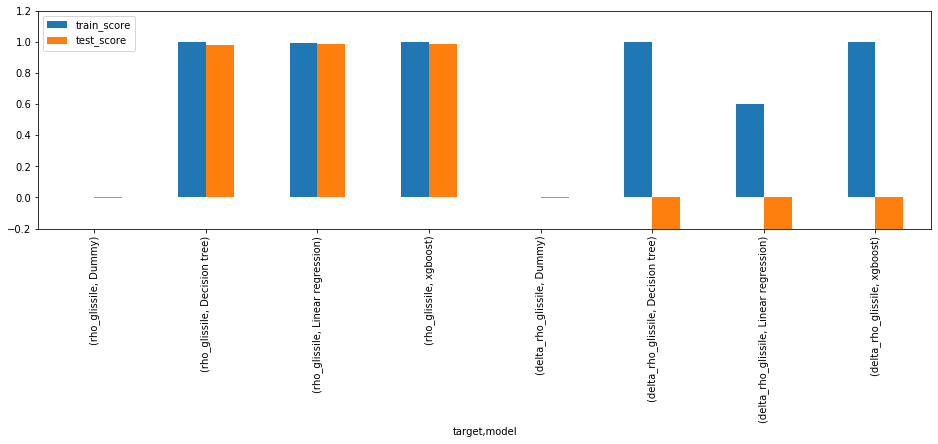

In [10]:
print(results)
results.set_index(['target', 'model']).plot(kind='bar', figsize=(16, 4), ylim=(-0.2, 1.2)) # alternative to indexing: xticks
plt.show()